# Import Modules

In [1]:
import os
import sys

import pickle
import pandas as pd

from ase.visualize import view

import chart_studio.plotly as py
import plotly.graph_objs as go
# #############################################################################
sys.path.insert(0, os.path.join(os.environ["PROJ_irox"], "data"))
from proj_data_irox import bulk_dft_data_path

# Script Inputs

In [2]:
raul_color = "red"
chris_color = "black"

# Read & Process DFT Data

## Read dataframe

In [3]:
with open(bulk_dft_data_path, "rb") as fle:
    df_bulk_dft = pickle.load(fle)
    df = df_bulk_dft

## Filter only systems shared by Chris and Raul DFT calcs

In [4]:
shared_indices = list(
    set(list(df[df["source"] == "raul"].index))
    &
    set(list(df[df["source"] == "chris"].index))
    )
print("Number of shared calculations: ", len(shared_indices))
df_shared = df.loc[shared_indices]

Number of shared calculations:  74


In [5]:
grouped = df_shared.reset_index().groupby(["id_unique"])
data_list = []
for name, group in grouped:

    data_dict_i = {
        "id_unique": name,
        "e_diff": None,
        "v_diff": None,
        "e_diff_abs": None,
        "v_diff_abs": None,
        }

    row_raul = group[group["source"] == "raul"]
    row_chris = group[group["source"] == "chris"]


    e_diff = row_raul["energy_pa"].iloc[0] - row_chris["energy_pa"].iloc[0]
    e_diff_abs = abs(e_diff)

    atoms_raul = row_raul.iloc[0]["atoms"]
    atoms_chris = row_chris.iloc[0]["atoms"]

    vol_pa_raul = atoms_raul.get_volume() / atoms_raul.get_number_of_atoms()
    vol_pa_chris = atoms_chris.get_volume() / atoms_chris.get_number_of_atoms()

    v_diff = vol_pa_raul - vol_pa_chris
    v_diff_abs = abs(v_diff)


    data_dict_i["e_diff"] = e_diff
    data_dict_i["v_diff"] = v_diff

    data_dict_i["v_diff_abs"] = v_diff_abs
    data_dict_i["e_diff_abs"] = e_diff_abs


    data_list.append(data_dict_i)

df_comp = pd.DataFrame(data_list)

df_comp = df_comp.set_index("id_unique")

# Creating main traces

In [6]:
def method(row_i, argument_0, raul_color=None, chris_color=None, df_comp=None):
    id_unique = row_i.name
    source_i = row_i["source"]
    atoms_i = row_i["atoms"]
    energy_pa = row_i["energy_pa"]

    e_diff = df_comp.loc[id_unique]["e_diff"]
    # #########################################################################
    new_column_values_dict = {
        "trace": None,
        }

    # #########################################################################
    if source_i == "raul":
        color_0 = raul_color
        showlegend_i = True
        marker_shape = "diamond"
    elif source_i == "chris":
        color_0 = chris_color
        showlegend_i = False
        marker_shape = "circle"

    volume_i = atoms_i.get_volume()
    num_atoms_i = atoms_i.get_number_of_atoms()
    volume_pa = volume_i / num_atoms_i

    trace_i = go.Scatter(
        x=[volume_pa],
        y=[energy_pa],
        mode="markers",
        legendgroup=id_unique,
        showlegend=showlegend_i,
        name=id_unique,
        marker=dict(
            symbol=marker_shape,

            # color=color_0,

            color=e_diff,
            colorscale='Viridis',
            colorbar=dict(thickness=10),

            size=12,
            line=dict(
                color='MediumPurple',
                width=1.,
                )
            ),

        )
    new_column_values_dict["trace"] = trace_i

    # #########################################################################
    for key, value in new_column_values_dict.items():
        row_i[key] = value
    return(row_i)

df_i = df_shared

arg1 = "TEMP_0"
# df_i["column_name"] = df_i.apply(
df_i = df_i.apply(
    method,
    axis=1,
    args=(arg1, ),
    raul_color=raul_color,
    chris_color=chris_color,
    df_comp=df_comp,
    )
df_shared = df_i

# Creating connections between data

In [7]:
grouped = df_shared.reset_index().groupby(["id_unique"])
connecting_lines_data = []
for name, group in grouped:

    assert len(group) == 2, "JIDFJSDI"

    row_0 = group.iloc[0]
    row_1 = group.iloc[1]

    vol_0 = row_0["atoms"].get_volume() / row_0["atoms"].get_number_of_atoms()
    vol_1 = row_1["atoms"].get_volume() / row_1["atoms"].get_number_of_atoms()


    energy_pa_0 = row_0["energy_pa"]
    energy_pa_1 = row_1["energy_pa"]

    trace_i = go.Scatter(
        x=[vol_0, vol_1],
        y=[energy_pa_0, energy_pa_1],
        mode="lines",
        legendgroup=name,
        showlegend=False,
        line=dict(
            color="grey",
            width=1.,
#             dash="dot",
            ),

        )

    connecting_lines_data.append(trace_i)

# Plotting

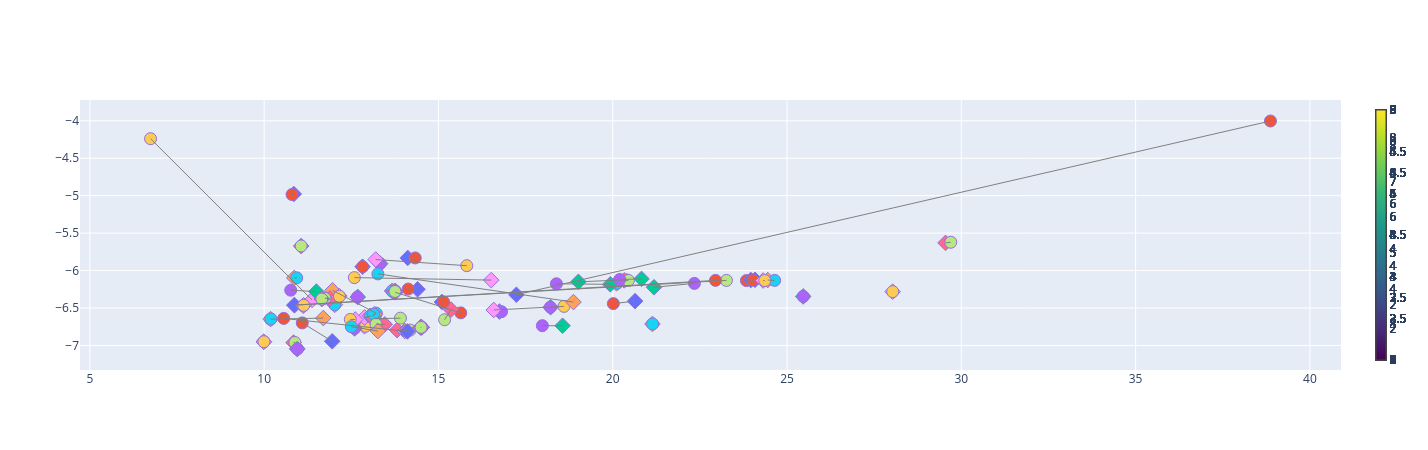

In [12]:
data = [] + \
    df_shared["trace"].tolist() + \
    connecting_lines_data + \
    []



fig = go.Figure(data=data)
fig.update_layout(showlegend=False)

fig.show()

In [9]:
# view(df.loc["7ave8rzrzj"].iloc[1]["atoms"])

df.loc["7ave8rzrzj"]

,atoms,energy_pa,form_e_chris,id_old,path,source,stoich,energy
id_unique,,,,,,,,
7ave8rzrzj,"(Atom('O', [-0.84936, 0.0663, 4.7655], index=0...",-6.322998,NaN,622,/global/cscratch1/sd/flores12/IrOx_Project_tem...,raul,AB2,-37.937987
7ave8rzrzj,"(Atom('O', [-0.62983, 0.0591, 13.84731], index...",-4.003334,NaN,622,/mnt/f/GDrive/norskov_research_storage/00_proj...,chris,AB2,-24.020002


In [10]:
# df_tmp.sort_values("e_diff_abs", ascending=False)


# df_tmp[
#     (df_tmp["e_diff"] > 0.) &
#     (df_tmp["e_diff"] > 0.01)
#     ]

In [11]:
import colorlover as cl